In [1]:
import os
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image, ImageOps
from collections import OrderedDict, defaultdict, Counter
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import numpy as np
from pathlib import Path

/home/antonello03/anaconda3/envs/py31/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root = Path("synth_out")
top4styles = ["Impressionism", "Realism", "Baroque", "Romanticism"]

rmse_imgs, prs_imgs, cos_imgs = [], [], []

for style in top4styles:
    for i in range(3):
        rmse_imgs.append(Image.open(root / f"RMSE_{style}_{i}.jpg"))
        prs_imgs.append(Image.open(root / f"PRS_{style}_{i}.jpg"))
        cos_imgs.append(Image.open(root / f"COS_{style}_{i}.jpg"))

In [3]:
!pip install open-clip-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import torch
import torch.nn as nn
from os.path import expanduser  # pylint: disable=import-outside-toplevel
from urllib.request import urlretrieve  # pylint: disable=import-outside-toplevel
def get_aesthetic_model(clip_model="vit_l_14"):
    """load the aethetic model"""
    home = expanduser("~")
    cache_folder = home + "/.cache/emb_reader"
    path_to_model = cache_folder + "/sa_0_4_"+clip_model+"_linear.pth"
    if not os.path.exists(path_to_model):
        os.makedirs(cache_folder, exist_ok=True)
        url_model = (
            "https://github.com/LAION-AI/aesthetic-predictor/blob/main/sa_0_4_"+clip_model+"_linear.pth?raw=true"
        )
        urlretrieve(url_model, path_to_model)
    if clip_model == "vit_l_14":
        m = nn.Linear(768, 1)
    elif clip_model == "vit_b_32":
        m = nn.Linear(512, 1)
    else:
        raise ValueError()
    s = torch.load(path_to_model)
    m.load_state_dict(s)
    m.eval()
    return m

amodel= get_aesthetic_model(clip_model="vit_l_14")
amodel.eval()

import torch
from PIL import Image
import open_clip
model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')

/home/antonello03/anaconda3/envs/py31/lib/python3.11/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


In [10]:
rmse_scores = []
pearson_scores = []
cosine_scores = []
for img in rmse_imgs:
    image = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        prediction = amodel(image_features)
        rmse_scores.append(prediction.item())

for img in prs_imgs:
    image = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        prediction = amodel(image_features)
        pearson_scores.append(prediction.item())

for img in cos_imgs:
    image = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        prediction = amodel(image_features)
        cosine_scores.append(prediction.item())

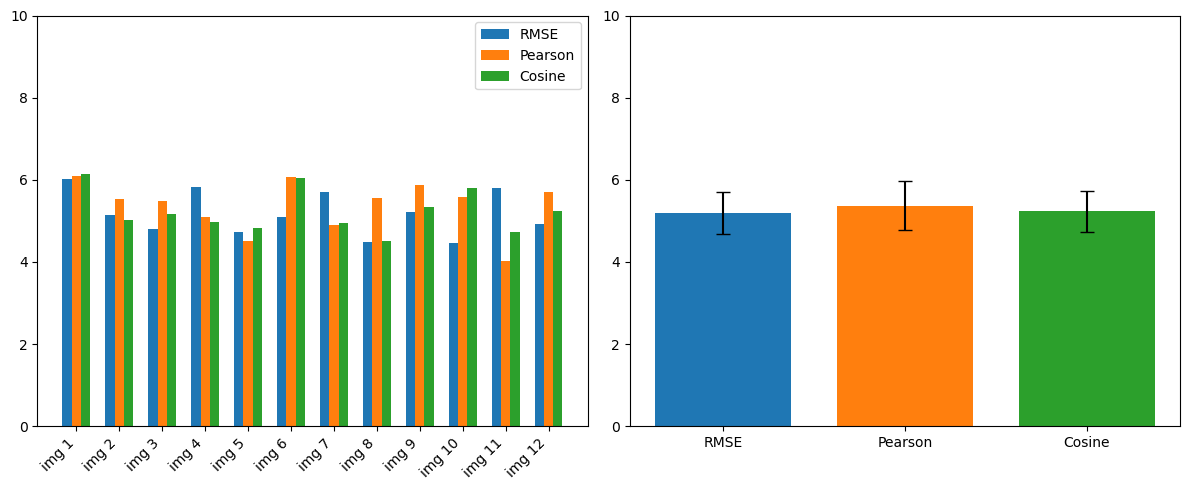

In [18]:
n = len(rmse_scores)
w = 0.25
base = np.arange(n) * (3*w + 0.4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(base - w, rmse_scores,   w, color='C0', label='RMSE')
ax1.bar(base,     pearson_scores, w, color='C1', label='Pearson')
ax1.bar(base + w, cosine_scores, w, color='C2', label='Cosine')
ax1.set_xticks(base)
ax1.set_xticklabels([f'img {i+1}' for i in range(n)], rotation=45, ha='right')
ax1.set_ylim(0, 10)
ax1.legend()

means = [np.mean(rmse_scores), np.mean(pearson_scores), np.mean(cosine_scores)]
stds  = [np.std(rmse_scores),  np.std(pearson_scores),  np.std(cosine_scores)]

x = np.arange(3)
ax2.bar(x, means, w*3, yerr=stds, capsize=5, color=['C0', 'C1', 'C2'])
ax2.set_xticks(x)
ax2.set_xticklabels(['RMSE', 'Pearson', 'Cosine'])
ax2.set_ylim(0, 10)

fig.tight_layout()
plt.show()


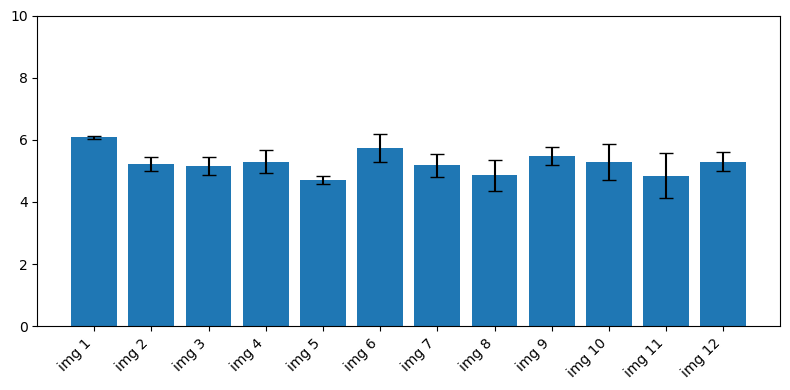

In [20]:
group_vals  = np.vstack([rmse_scores, pearson_scores, cosine_scores])
group_means = group_vals.mean(axis=0)
group_stds  = group_vals.std(axis=0)

x = np.arange(len(group_means))
plt.figure(figsize=(8, 4))
plt.bar(x, group_means, yerr=group_stds, capsize=5)
plt.xticks(x, [f'img {i+1}' for i in range(len(group_means))], rotation=45, ha='right')
plt.ylim(0, 10)
plt.tight_layout()
plt.show()
